# PLS for prediction of pectin yield from Carbohydrate microarray data

This notebook exemplifies the PLS modeling approach utilizing carbohydrate microarray data. The data used for this notebook was derived from Baum et al. [1]. Carbohydrate microarrays are typically equipped with multiple monoclonal antibodies and carbohydrate binding modules (CBM) which will bind to specific chemical structural domains of polysaccharides. Pectin is such a polysaccharide. It is typically extracted from citrus peel and used as a gelling agent in jams etc. In the following we will establish Partial Least Squares (PLS) prediction models for pectin yield from the underlying carbohydrate binding pattern. Or said in a different way we want to find a PLS model which we could use on a newly measured carbydrate microarray row to predict its pectin yield. 

## Import dependencies and load data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

extraction1 = pd.read_pickle('extraction1.pkl')
extraction2 = pd.read_pickle('extraction2.pkl')
extraction3 = pd.read_pickle('extraction3.pkl')

## Plot carbohydrate microarray data
During the study by Baum et al. [1] three extractions of pectin were carried out. These are shown as heatmaps below. Each extraction indicates its reference values $y$ (pectin yield) at its rows. The extracted samples were measured against 30 monoclonal antibodies/CBMs (columns). Lighter color in the individual cells resemble high degree of interaction between antibody/CBM with the respective pectin.

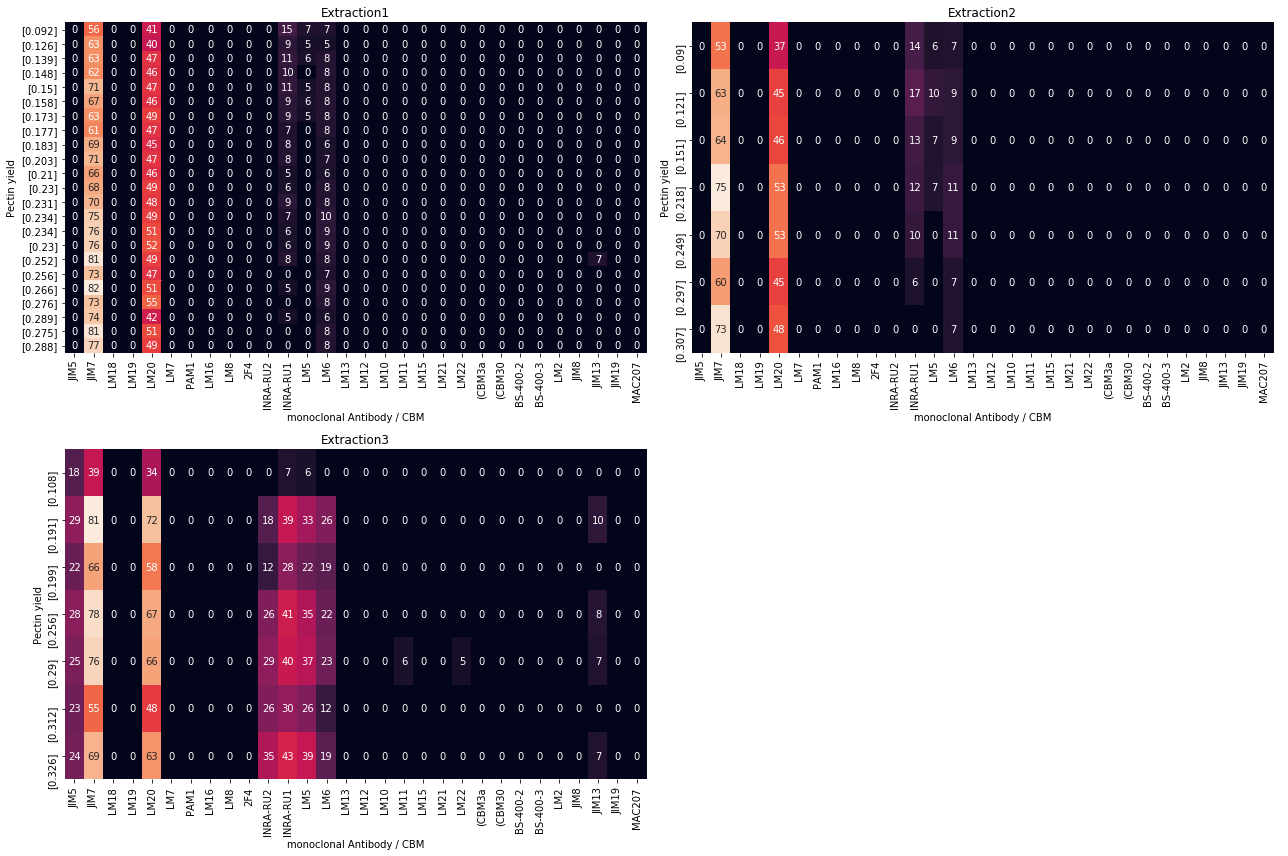

In [2]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(18,12))
sns.heatmap(extraction1, ax=ax[0][0], annot=True, cbar=False)
sns.heatmap(extraction2, ax=ax[0][1], annot=True, cbar=False)
sns.heatmap(extraction3, ax=ax[1][0], annot=True, cbar=False)
ax[1][1].axis('off')

ax[0][0].set_title('Extraction1')
ax[0][1].set_title('Extraction2')
ax[1][0].set_title('Extraction3')
ax[0][0].set_xlabel('monoclonal Antibody / CBM')
ax[0][1].set_xlabel('monoclonal Antibody / CBM')
ax[1][0].set_xlabel('monoclonal Antibody / CBM')
ax[0][0].set_ylabel('Pectin yield')
ax[0][1].set_ylabel('Pectin yield')
ax[1][0].set_ylabel('Pectin yield')
plt.tight_layout()

## Concatenate data
To perform PLS modeling all three extractions are concatenated into a single matrix $X$ for PLS modeling. Pectin yields resemble reference values $y$ for supervised learning.

In [3]:
extractions_all = pd.concat((extraction1, extraction2, extraction3),axis=0)
yield_all = extractions_all.index

Text(60,0.5,'Pectin yield')

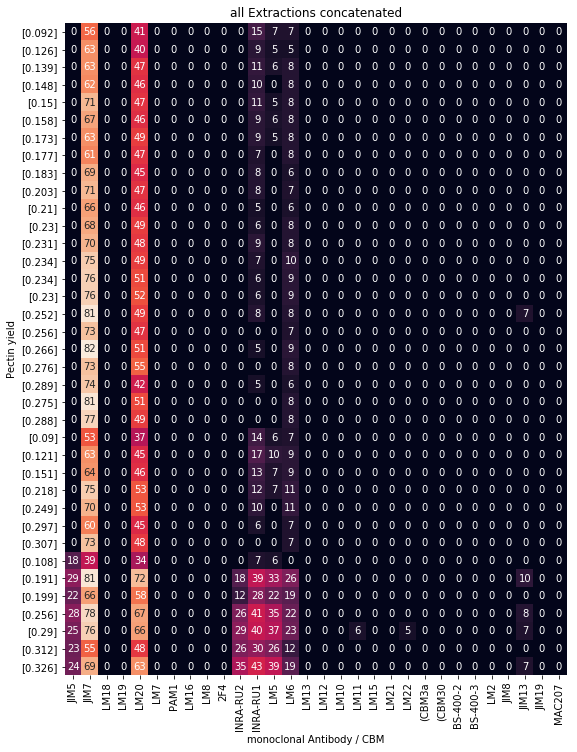

In [4]:
plt.figure(figsize=(9,12))
sns.heatmap(extractions_all, annot=True, cbar=False)
plt.title('all Extractions concatenated')
plt.xlabel('monoclonal Antibody / CBM')
plt.ylabel('Pectin yield')

## Perform leave-one-out Cross Validation for parameter tuning
To find the number of latent variables (LV) we perform loo CV. Typically it is advised to perform 5-fold CV to avoid from overfitting. However, in this example the number of samples are quite limited, hence the choice for loo CV.

Text(0.5,1,'Find the right number of LVs')

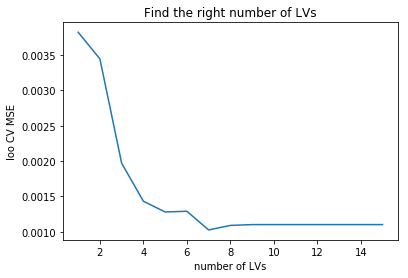

In [29]:
from mbpls.mbpls import MBPLS
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error

MSEs = []
for lv in range(15):
    mbpls = MBPLS(n_components=lv+1, method='NIPALS')
    prediction = cross_val_predict(mbpls, extractions_all, yield_all, cv=len(extractions_all))
    prediction = pd.DataFrame(prediction)
    MSEs.append(mean_squared_error(prediction, yield_all))

plt.plot(np.arange(1,16), MSEs)
plt.xlabel('number of LVs')
plt.ylabel('loo CV MSE')
plt.title('Find the right number of LVs')

Finally, we show the calibration for a model with 5 LVs. The actual MSE minimum indicates 7 LVs. However, we want to prevent from overfitting and choose only 5 LVs (increased bias).

Text(0.5,1,'MSE = 0.0013')

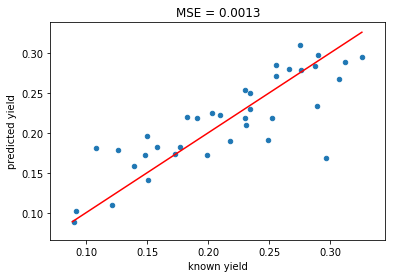

In [31]:
mbpls = MBPLS(n_components=5, method='NIPALS')
prediction = cross_val_predict(mbpls, extractions_all, yield_all, cv=len(extractions_all))
prediction = pd.DataFrame(prediction)
yield_all = pd.DataFrame(np.array(yield_all))
prediction = pd.concat((prediction, yield_all), axis=1)
prediction.columns=['predicted yield', 'known yield']
prediction.plot.scatter(x='known yield', y='predicted yield')
plt.plot([prediction.min().min(), prediction.max().max()], [prediction.min().min(), prediction.max().max()], color='red')
plt.title('MSE = %.4f' % mean_squared_error(prediction['known yield'], prediction['predicted yield']))

The calibration above indicates that carbohydrate microarrays can be used to predict pectin yield. The expected mean square error (MSE) would be around 0.0013 units

## Let's look at the regression vector $\beta$
To calculate the regression vector $\beta$ we first need to calculate a global model using our 5 LVs (we found these in the parameter tuning section). 

Text(141,0.5,'Pectin yield')

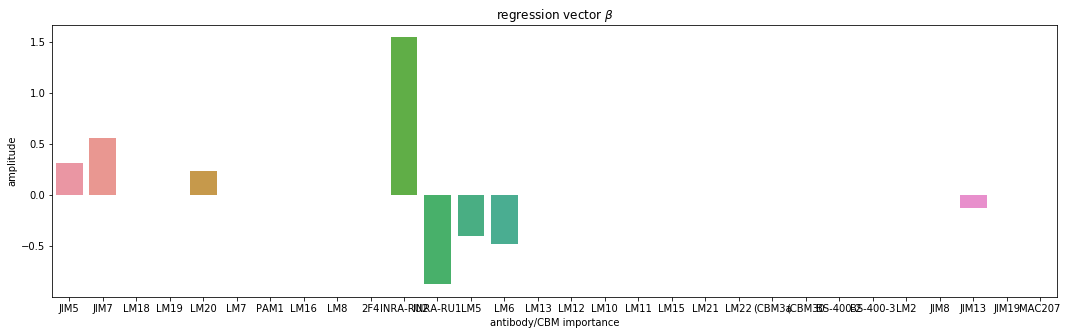

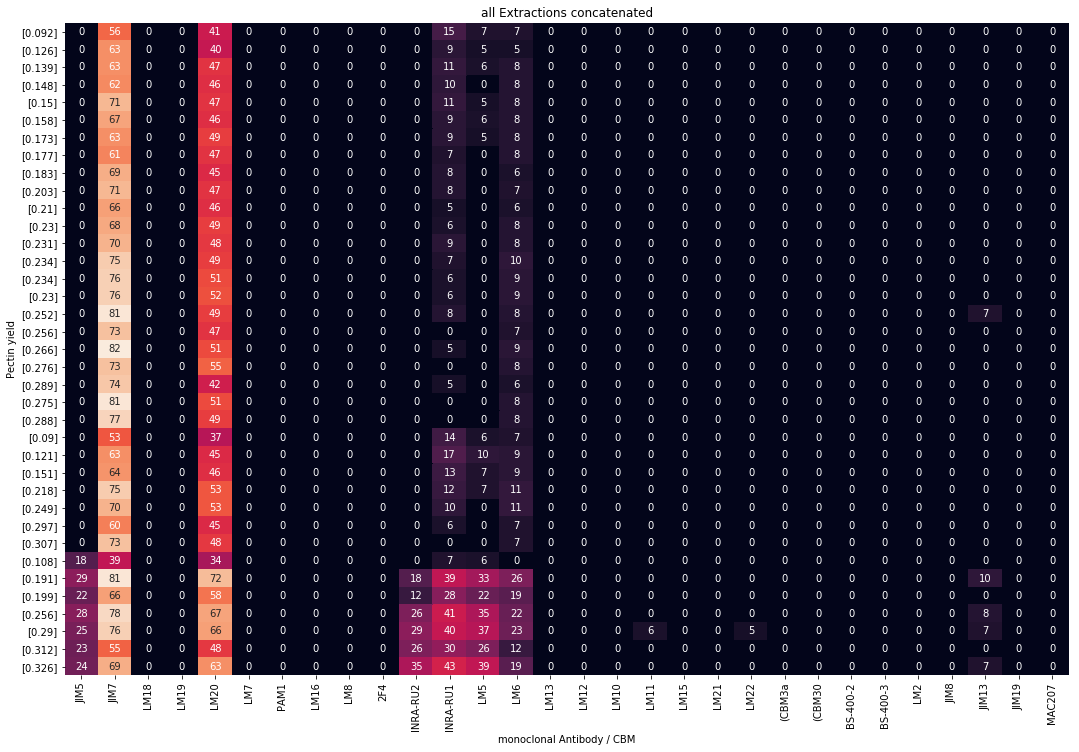

In [64]:
import seaborn as sns
mbpls = MBPLS(n_components=5, method='NIPALS')
mbpls.fit_transform(extractions_all, yield_all)
plt.figure(figsize=(18,5))
sns.barplot(x=extraction1.columns, y=mbpls.beta_[:,0])
plt.title('regression vector $\\beta$')
plt.xlabel('antibody/CBM importance')
plt.ylabel('amplitude')

plt.figure(figsize=(18,12))
sns.heatmap(extractions_all, annot=True, cbar=False)
plt.title('all Extractions concatenated')
plt.xlabel('monoclonal Antibody / CBM')
plt.ylabel('Pectin yield')

From the regression vector $\beta$ (see above) one can read which antibody/CBM  are important for prediction of prectin yield. Additionally, the sign of the individual coefficents indicates positiv or negativ correlation, respectively.